In [172]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')




from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [198]:


class bikeSales:
    
    
    file = 'clean_sport2.csv'
    df = None
    scaled_df = None
    model = None
    
    
    
    
    def read_data(self):
        df = pd.read_csv(self.file,
                         parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                         infer_datetime_format=True)
        self.df = df
        return


    def add_dummy_variables(self, categorical_features=None):
    
        if (categorical_features == None):
            categorical_features = self.df.select_dtypes(exclude='number').columns
        
        additional = pd.get_dummies(self.df[categorical_features])
        self.df[additional.columns] = additional
        
        self.df.drop(categorical_features, axis=1, inplace=True)
        return

    def feature_plot(model,X,top=10):

        feats_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['FeatureImportance'])
        feats_imp = feats_imp.sort_values('FeatureImportance', ascending=False)[:top]

        feats_imp.plot(kind='barh', figsize=(12,6), legend=False)
        plt.title('Feature Importance from XgBoost Classifier')
        sns.despine(left=True, bottom=True)
        plt.gca().invert_yaxis()
        return

    def plot_accuracy_predictions(self, y_test, pred):
        fig, ax = plt.subplots(figsize=(12,10))
        ax.scatter(y_test,pred)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=0.8)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('Accuracy of Predictions')
        return
    
    
    def scale_data(self, target='Price'):
        local_df = self.df.select_dtypes(include='number')

        features = list(set(local_df.columns) - set([target]))

        sc = StandardScaler()
        sc.fit(self.df[features])
        s = sc.transform(self.df[features])
        self.scaled_df = pd.DataFrame(s,columns=features)

        return
    
    
    def adjusted_r2(self, r2, n, k):
        return 1 - (1-r2)*((n-1)/(n-k-1)) 



    def find_best_model(self, features, y, scaled=False):

        X = self.df[features]
        y = self.df['Price']
        
        if scaled == True:
            X = self.scaled_df[features]
            

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

        best_model = {'model': 'default model',
                      'score': 0}
        models = []

        models.append(("LassoCV",LassoCV(cv=5)))
        models.append(("LinearRegression",LinearRegression()))
        models.append(("PassiveAggressiveRegressor",PassiveAggressiveRegressor()))
        models.append(("RidgeCV",RidgeCV(cv=5)))
        models.append(("Bagging",BaggingRegressor()))
        models.append(("SVR",SVR()))

        n,k = X_train.shape

        for name, model in models:
            score = cross_val_score(model, X_train, y_train,  cv=5)

            result = self.adjusted_r2(score,n,k)
                    
            if (result.mean() > best_model['score']):
                best_model['model'] = model
                best_model['score'] = result.mean()
            
        
        return best_model['model']


    def fit(self, X, y):
        self.model.fit(X, y)
        
    def predict(self,X):
        return self.model.predict(X)
    
    def deal_type(self):
#         if ('Predicted_Price' not in list(self.df.columns)):
#             raise 
        
        self.df['Price_ratio'] = self.df['Price'] / self.df['Predicted_Price']

        self.df['Deal_type'] = 'Dont Bother'
        self.df['Deal_type'][self.df['Price_ratio'] > 1.1] = 'Negotiate'
        self.df['Deal_type'][self.df['Price_ratio'] > 1.2] = 'Good Deal'
        self.df['Deal_type'][self.df['Price_ratio'] > 1.5] = 'Great Deal'
        self.df['Deal_type'][self.df['Price_ratio'] > 2] = 'Its a steal'

        return
        
    
    def plot_deals(self,x,y,hue=None,title='',figsize=(12,10)):
        ax = plt.figure(figsize=figsize)
        sns.scatterplot(x=x,y=y,hue=hue,data=self.df);
        plt.title(title,fontsize=14)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #plt.ylim(0,40000)




In [199]:
sport = bikeSales()


In [200]:
sport.read_data()

In [201]:
sport.df.shape

(2177, 76)

In [202]:
sport.add_dummy_variables()

In [203]:
sport.df.shape

(2177, 1529)

In [204]:
sport.scale_data(target='Price')
sport.scaled_df.describe()

,Suburb_Bondi junction,Model_f4 rr,Suburb_Banksia,Model_Ninja h2 zx1000n,Suburb_Emerald,Engine_Config_V4,Suburb_Schofields,Suburb_Elphinstone,Suburb_Kariong,Bike_CBR600RRA,...,Bike_Hayabusa MY16 Road Manual 6sp,Suburb_Goodna,Suburb_Spearwood,Suburb_Kinross,Suburb_Preston,Suburb_Shepparton north,Suburb_Albert park,Suburb_Nambucca heads,Bike_RS4 125 Road Manual 6sp 125cc,Suburb_Windsor gardens
count,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,...,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03
mean,-7.099856e-17,3.247606e-17,4.429131e-16,4.157663e-16,-4.162380e-17,3.206872e-16,3.247606e-17,3.247606e-17,7.490627e-17,4.531126e-16,...,4.741174e-16,-2.244001e-16,3.247606e-17,2.519708e-16,2.625847e-16,3.935472e-16,4.257778e-16,2.601304e-16,7.976381e-16,2.921858e-17
std,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,...,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00
min,-3.032392e-02,-2.143732e-02,-2.143732e-02,-4.797943e-02,-3.032392e-02,-1.055805e-01,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,...,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-4.797943e-02,-2.143732e-02
25%,-3.032392e-02,-2.143732e-02,-2.143732e-02,-4.797943e-02,-3.032392e-02,-1.055805e-01,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,...,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-4.797943e-02,-2.143732e-02
50%,-3.032392e-02,-2.143732e-02,-2.143732e-02,-4.797943e-02,-3.032392e-02,-1.055805e-01,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,...,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-4.797943e-02,-2.143732e-02
75%,-3.032392e-02,-2.143732e-02,-2.143732e-02,-4.797943e-02,-3.032392e-02,-1.055805e-01,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,...,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-4.797943e-02,-2.143732e-02
max,3.297726e+01,4.664762e+01,4.664762e+01,2.084226e+01,3.297726e+01,9.471448e+00,4.664762e+01,4.664762e+01,4.664762e+01,4.664762e+01,...,4.664762e+01,3.297726e+01,4.664762e+01,4.664762e+01,4.664762e+01,4.664762e+01,4.664762e+01,4.664762e+01,2.084226e+01,4.664762e+01


In [205]:
niave_feature = ['Kilometers','Age']
sport.model = sport.find_best_model(niave_feature, sport.df['Price'])





In [206]:
sport.fit(sport.df[niave_feature],sport.df['Price'])
predictions = sport.predict(sport.df[niave_feature])


In [207]:
sport.df['Predicted_Price'] = predictions
sport.df[['Price','Predicted_Price']].head()

,Price,Predicted_Price
0,1500.0,5766.422408
1,1700.0,9793.277150
2,1900.0,4239.099500
3,1990.0,5903.430252
4,1999.0,7352.072148


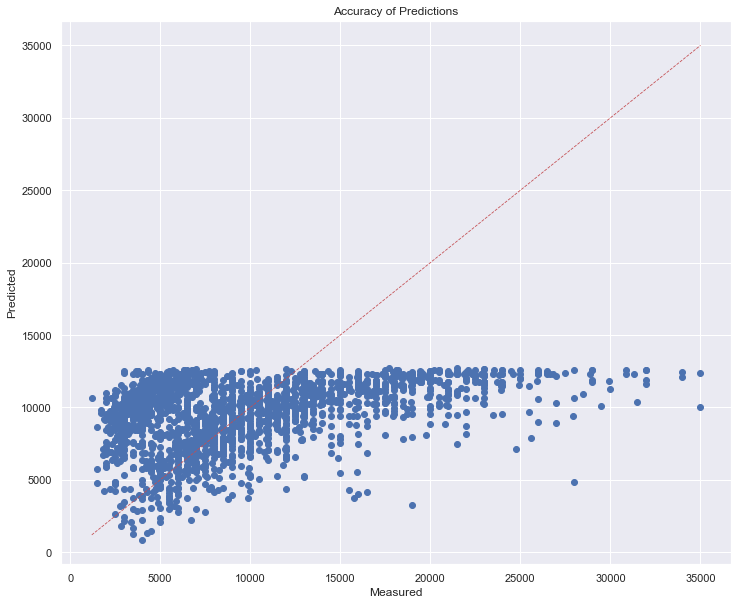

In [208]:
sport.plot_accuracy_predictions(sport.df['Price'],sport.df['Predicted_Price'])

In [209]:
sport.deal_type()

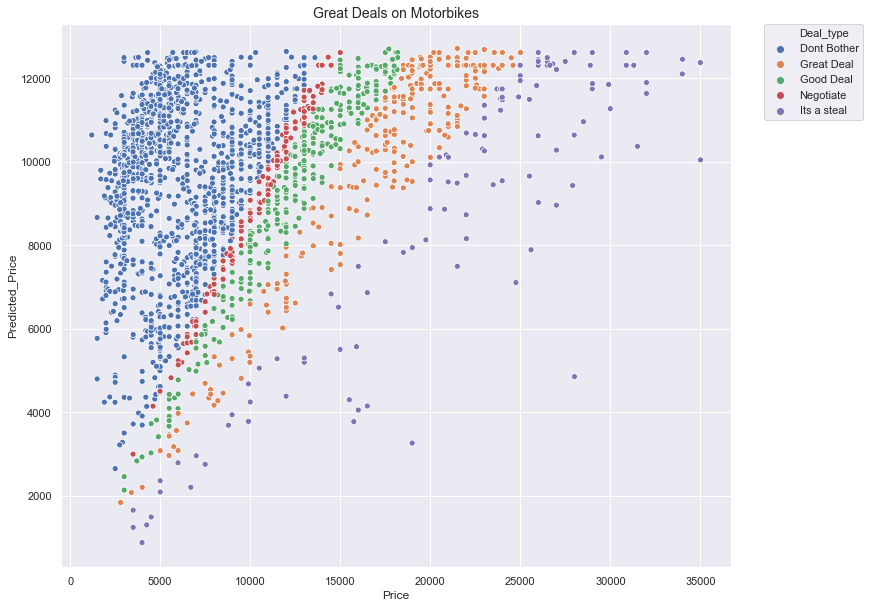

In [210]:
sport.plot_deals(x='Price',y='Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')


In [211]:
sport.df.head()

,Bore,Carburettor(s),Compression_Ratio,Cylinders,Dry_Weight,Engine_Description,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Reserve_Capacity,Fuel_Tank_Capacity,...,Model_f4 312 r 1000 11,Model_f4 750 s,Model_f4 750 s f4s 11,Model_f4 r,Model_f4 rr,Model_f4 rr 1000,Model_f4ago 1000,Predicted_Price,Price_ratio,Deal_type
0,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,5766.422408,0.260127,Dont Bother
1,62.0,2.0,11.0,2.0,129.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,9793.277150,0.173588,Dont Bother
2,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,4239.099500,0.448208,Dont Bother
3,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,5903.430252,0.337092,Dont Bother
4,48.6,4.0,10.0,4.0,129.0,250.0,296.0,118.0,3.459387,13.0,...,0,0,0,0,0,0,0,7352.072148,0.271896,Dont Bother


In [212]:
sport.model

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [216]:
bike_cols = [col for col in sport.df.columns if 'Bike' in col]
brand_cols = [col for col in sport.df.columns if 'Brand' in col]
model_cols = [col for col in sport.df.columns if 'Model' in col]
niave_feature = ['Kilometers','Age']


features = [niave_feature, bike_cols, brand_cols, model_cols]

for i, col in enumerate(features):
    
    sport.model = sport.find_best_model(col, sport.df['Price'])
    
    sport.fit(sport.df[niave_feature],sport.df['Price'])
    
    predictions = sport.predict(sport.df[niave_feature])
    sport.df['Predicted_Price_'+str(i)] = predictions

    
    
    

In [217]:
pred_cols = [col for col in sport.df.columns if 'Predicted' in col]
sport.df[pred_cols].head()

,Predicted_Price,Predicted_Price_0,Predicted_Price_1,Predicted_Price_2,Predicted_Price_3
0,5766.422408,5766.422408,5766.422408,5317.638077,5766.422408
1,9793.277150,9793.277150,9793.277150,9997.887675,9793.277150
2,4239.099500,4239.099500,4239.099500,3502.268535,4239.099500
3,5903.430252,5903.430252,5903.430252,4923.078853,5903.430252
4,7352.072148,7352.072148,7352.072148,6921.687257,7352.072148
